# Generate music with an LSTM Network

This notebook is based on the programming assignment "Improvise a Jazz Solo with an LSTM network" of deeplearning.ai, course Sequence Models, week Recurrent Neural Networks. The figures and the functions data_processing_vmg, load_music_utils_vmg and generate_music_vmg are also taken from that assignment.

We will build an LSTM network to generate music.

## Learning objectives

- Application of Long short-term memory (LSTM) neural network in TensorFlow
- Use of Adam optimizer with decaying learning rate
- Use of GPU for the training of the model

In [1]:
from __future__ import print_function
import IPython
import sys
from music21 import *
import numpy as np
from grammar import *
from qa import *
from preprocess import * 
from music_utils import *
from data_utils import *

import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
print(tf.__version__)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

C:\Users\vgkortsas\AppData\Local\Continuum\anaconda3\envs\TF_practice\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vgkortsas\AppData\Local\Continuum\anaconda3\envs\TF_practice\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vgkortsas\AppData\Local\Continuum\anaconda3\envs\TF_practice\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

1.14.0


In [2]:
import warnings

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


I modified the function data_processing so that X and Y have the same shape

In [3]:
def data_processing_vmg(corpus, values_indices, m = 60, Tx = 30):
    # cut the corpus into semi-redundant sequences of Tx values
    Tx = Tx 
    N_values = len(set(corpus))
    np.random.seed(0)
    X = np.zeros((m, Tx, N_values), dtype=np.bool)
    Y = np.zeros((m, Tx, N_values), dtype=np.bool)
    for i in range(m):
#         for t in range(1, Tx):
        random_idx = np.random.choice(len(corpus) - Tx)
        corp_data = corpus[random_idx:(random_idx + Tx)]
        for j in range(Tx):
            idx = values_indices[corp_data[j]]
            if j != 0:
                X[i, j, idx] = 1
                Y[i, j-1, idx] = 1
    
    #Y = np.swapaxes(Y,0,1) # VMG: I commented this line
    #Y = Y.tolist() # VMG: I commented this line
    return np.asarray(X), np.asarray(Y), N_values 

In [4]:
def load_music_utils_vmg():
    chords, abstract_grammars = get_musical_data('data/original_metheny.mid')
    corpus, tones, tones_indices, indices_tones = get_corpus_data(abstract_grammars)
    N_tones = len(set(corpus))
    X, Y, N_tones = data_processing_vmg(corpus, tones_indices, 60, 30)   
    return (X, Y, N_tones, indices_tones)

In [5]:
def generate_music_vmg(checkpoint, num_classes, lstm_size, T_y,corpus = corpus, abstract_grammars = abstract_grammars, tones = tones, tones_indices = tones_indices, indices_tones = indices_tones, max_tries = 1000, diversity = 0.5):
    """
    Generates music using a model trained to learn musical patterns of a jazz soloist. Creates an audio stream
    to save the music and play it.
    
    Arguments:
    corpus -- musical corpus, list of 193 tones as strings (ex: 'C,0.333,<P1,d-5>')
    abstract_grammars -- list of grammars, on element can be: 'S,0.250,<m2,P-4> C,0.250,<P4,m-2> A,0.250,<P4,m-2>'
    tones -- set of unique tones, ex: 'A,0.250,<M2,d-4>' is one element of the set.
    tones_indices -- a python dictionary mapping unique tone (ex: A,0.250,< m2,P-4 >) into their corresponding indices (0-77)
    indices_tones -- a python dictionary mapping indices (0-77) into their corresponding unique tone (ex: A,0.250,< m2,P-4 >)
    Tx -- integer, number of time-steps used at training time
    temperature -- scalar value, defines how conservative/creative the model is when generating music
    
    Returns:
    predicted_tones -- python list containing predicted tones
    """
    
    # set up audio stream
    out_stream = stream.Stream()
    
    # Initialize chord variables
    curr_offset = 0.0                                     # variable used to write sounds to the Stream.
    num_chords = int(len(chords) / 3)                     # number of different set of chords
    
    print("Predicting new values for different set of chords.")
    # Loop over all 18 set of chords. At each iteration generate a sequence of tones
    # and use the current chords to convert it into actual sounds 
    for i in range(1, num_chords):
        
        # Retrieve current chord from stream
        curr_chords = stream.Voice()
        
        # Loop over the chords of the current set of chords
        for j in chords[i]:
            # Add chord to the current chords with the adequate offset, no need to understand this
            curr_chords.insert((j.offset % 4), j)
        
        # Generate a sequence of tones using the model
        indices = predict_and_sample_vmg(checkpoint=checkpoint, num_classes=num_classes, lstm_size=lstm_size, T_y=T_y)
        #print(type(indices))
        indices = list(indices.squeeze())
        pred = [indices_tones[p] for p in indices]
        
        predicted_tones = 'C,0.25 '
        for k in range(len(pred) - 1):
            predicted_tones += pred[k] + ' ' 
        
        predicted_tones +=  pred[-1]
                
        #### POST PROCESSING OF THE PREDICTED TONES ####
        # We will consider "A" and "X" as "C" tones. It is a common choice.
        predicted_tones = predicted_tones.replace(' A',' C').replace(' X',' C')

        # Pruning #1: smoothing measure
        predicted_tones = prune_grammar(predicted_tones)
        
        # Use predicted tones and current chords to generate sounds
        sounds = unparse_grammar(predicted_tones, curr_chords)

        # Pruning #2: removing repeated and too close together sounds
        sounds = prune_notes(sounds)

        # Quality assurance: clean up sounds
        sounds = clean_up_notes(sounds)

        # Print number of tones/notes in sounds
        print('Generated %s sounds using the predicted values for the set of chords ("%s") and after pruning' % (len([k for k in sounds if isinstance(k, note.Note)]), i))
        
        # Insert sounds into the output stream
        for m in sounds:
            out_stream.insert(curr_offset + m.offset, m)
        for mc in curr_chords:
            out_stream.insert(curr_offset + mc.offset, mc)

        curr_offset += 4.0
        
    # Initialize tempo of the output stream with 130 bit per minute
    out_stream.insert(0.0, tempo.MetronomeMark(number=130))

    # Save audio stream to fine
    mf = midi.translate.streamToMidiFile(out_stream)
    mf.open("output/my_music_vmg.midi", 'wb')
    mf.write()
    print("Your generated music is saved in output/my_music.midi")
    mf.close()
    
    # Play the final stream through output (see 'play' lambda function above)
    # play = lambda x: midi.realtime.StreamPlayer(x).play()
    # play(out_stream)
    
    return out_stream

In [6]:
X, Y, n_values, indices_values = load_music_utils_vmg()
print('shape of X:', X.shape)
print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_values)
print('Shape of Y:', Y.shape)

shape of X: (60, 30, 78)
number of training examples: 60
Tx (length of sequence): 30
total # of unique values: 78
Shape of Y: (60, 30, 78)


- `X`: This is an (m, $T_x$, 78) dimensional array. We have m training examples, each of which is a snippet of $T_x =30$ musical values. At each time step, the input is one of 78 different possible values, represented as a one-hot vector. 

- `Y`: This is essentially the same as `X`, but shifted one step to the left (to the past). We're interested in the network using the previous values to predict the next value, so our sequence model will try to predict $y^{\langle t \rangle}$ given $x^{\langle 1\rangle}, \ldots, x^{\langle t \rangle}$. 

- `n_values`: The number of unique values in this dataset. This should be 78. 

- `indices_values`: python dictionary mapping from 0-77 to musical values.

In [7]:
indices_values

{0: 'X,0.250,<A4,d-2>',
 1: 'A,0.250,<P-4,d-8>',
 2: 'C,0.250,<P4,m-2>',
 3: 'S,0.250,<dd5,d1>',
 4: 'S,0.250,<d4,M-2>',
 5: 'C,0.250,<P11,M7>',
 6: 'S,0.250,<P5,A1>',
 7: 'C,0.250,<d4,M-2>',
 8: 'C,0.250,<d5,P1>',
 9: 'C,0.500,<m6,M2>',
 10: 'S,0.250,<M-2,m-6>',
 11: 'S,0.250,<d1,P-5>',
 12: 'C,0.333,<A4,d-2>',
 13: 'C,0.250,<A-4,P-8>',
 14: 'A,0.333,<A4,d-2>',
 15: 'C,0.333,<P1,d-5>',
 16: 'A,0.250,<m2,P-4>',
 17: 'C,0.250,<M2,d-4>',
 18: 'C,0.667,<d6,m2>',
 19: 'C,0.333,<d1,P-5>',
 20: 'S,0.333,<d1,P-5>',
 21: 'C,0.250,<dd5,d1>',
 22: 'S,0.250,<m2,P-4>',
 23: 'S,0.250,<d5,P1>',
 24: 'A,0.250,<M3,d-3>',
 25: 'C,0.333,<M2,d-4>',
 26: 'C,0.250,<m-2,d-6>',
 27: 'C,0.250',
 28: 'S,0.250,<P4,m-2>',
 29: 'C,0.333,<m7,M3>',
 30: 'S,0.333,<m2,P-4>',
 31: 'A,0.250,<d5,P1>',
 32: 'A,0.250,<P1,d-5>',
 33: 'C,0.500,<P4,m-2>',
 34: 'C,0.333,<P5,A1>',
 35: 'C,0.250,<P1,d-5>',
 36: 'C,0.250,<A4,d-2>',
 37: 'C,0.250,<P5,A1>',
 38: 'S,0.333,<d7,m3>',
 39: 'S,0.250,<m3,m-3>',
 40: 'A,0.250,<d4,M-2>',


In [8]:
X[0,1,:]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False])

In [9]:
Y[0,0,:]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False])

## Network architecture

<img src="images/music_generation.png" style="width:600;height:400px;">

<!--
<img src="images/djmodel.png" style="width:600;height:400px;">
<br>
<caption><center> **Figure 1**: LSTM model. $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a window of size $T_x$ scanned over the musical corpus. Each $x^{\langle t \rangle}$ is an index corresponding to a value (ex: "A,0.250,< m2,P-4 >") while $\hat{y}$ is the prediction for the next value  </center></caption>
!--> 

We will be training the model on random snippets of 30 values taken from a much longer piece of music. Thus, we won't bother to set the first input $x^{\langle 1 \rangle} = \vec{0}$, which we had done in a previous project to denote the start of a name, since now most of these snippets of audio start somewhere in the middle of a piece of music. We are setting each of the snippets to have the same length $T_x = 30$ to make vectorization easier. 

In [10]:
def get_batches(x, y, batch_size):
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [11]:
def build_inputs(batch_size, num_steps, num_classes):
    
    inputs = tf.placeholder(tf.float32,[batch_size,num_steps,num_classes],name='inputs')
    targets = tf.placeholder(tf.float32,[batch_size,num_steps,num_classes], name='targets')
    
    return inputs, targets

In [12]:
def build_lstm(lstm_size, lstm_layers, batch_size):
    
    # Your basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size) 
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([lstm for _ in range(lstm_layers)])
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, initial_state

In [13]:
def build_output(lstm_output, in_size, out_size):

    # Reshape output so it's a bunch of rows, one row for each step for each sequence.
    # Concatenate lstm_output over axis 1 (the columns)
    seq_output = tf.concat(lstm_output,axis=1)
    # Reshape seq_output to a 2D tensor with lstm_size columns
    x = tf.reshape(seq_output,[-1,in_size])
    
    # Connect the LSTM outputs to a softmax layer
    with tf.variable_scope('softmax'):
        # Create the weight and bias variables here
        softmax_w = tf.Variable(tf.truncated_normal([in_size, out_size]))
        softmax_b = tf.Variable(tf.zeros(out_size))
    
    # Since output is a bunch of rows of LSTM cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits = tf.add(tf.matmul(x,softmax_w),softmax_b)
    
    # Use softmax to get the probabilities for predicted characters
    out = tf.nn.softmax(logits)
    
    return out, logits

In [14]:
def build_loss(logits, targets, lstm_size, num_classes):
    
    targets_reshaped = tf.reshape(targets,[-1,num_classes]) 
        
    # Softmax cross entropy loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=targets_reshaped))
       
    return loss

We will use Adam optimizer with decaying learning rate. Using tf.train.inverse_time_decay the learning rate is 

decayed_learning_rate = learning_rate / (1 + decay_rate * global_step /decay_step)

The step variable global_step is updated for each mini-batch, not just for each epoch. However, in this case since each batch has size equal to the whole dataset, the global_step has the same value with the epoch value

In [15]:
def build_optimizer(loss, learning_rate, decay_rate):
    
    global_step = tf.Variable(0, trainable=False)
    decay_steps = 1.0
    learning_rate = tf.train.inverse_time_decay(learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step)
    
    return optimizer

In [16]:
class djmodel:
    
    def __init__(self, num_classes=78, batch_size=60, num_steps=30, 
                       lstm_size=64, lstm_layers=1, learning_rate=0.01, sampling=False):
    
        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size, num_steps = batch_size, num_steps

        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.inputs, self.targets = build_inputs(batch_size, num_steps, num_classes)

        # Build the LSTM cell
        cell, self.initial_state = build_lstm(lstm_size, lstm_layers, batch_size)
            
        ### Run the data through the RNN layers
        # self.inputs are already one-hot
        
        # Run each sequence step through the RNN with tf.nn.dynamic_rnn 
        outputs, state = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=self.initial_state)
        
        self.final_state = state

        # Get softmax predictions and logits
        self.prediction, self.logits = build_output(outputs, lstm_size, num_classes)
        
        
        # Loss and optimizer (with gradient clipping)
        self.loss =  build_loss(self.logits, self.targets, lstm_size, num_classes)
        self.optimizer = build_optimizer(self.loss, learning_rate, decay_rate)

In [17]:
batch_size = X.shape[0]       # Sequences per batch
num_steps = X.shape[1]          # Number of sequence steps per batch
lstm_size = 64         # Size of hidden layers in LSTMs
lstm_layers = 1          # Number of LSTM layers
num_classes=X.shape[2]
learning_rate = 0.01    # Learning rate
decay_rate=0.01

In [18]:
epochs = 200

model = djmodel(num_classes=num_classes, batch_size=batch_size, num_steps=num_steps, 
                lstm_size=lstm_size, lstm_layers=lstm_layers, learning_rate=learning_rate)


saver = tf.train.Saver() 

loss_vec = []
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
           
    iteration = 1
    
    for e in range(epochs):
        state = sess.run(model.initial_state) 
        
        for ii, (x, y) in enumerate(get_batches(X, Y, batch_size), 1):
            feed = {model.inputs: x,
                    model.targets: y,
                    model.initial_state: state}
            batch_loss, state,_= sess.run([model.loss, model.final_state,model.optimizer],
                                         feed_dict=feed)
            loss_vec.append(batch_loss)
            if iteration%10==0:
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Train loss: {:.3f}".format(batch_loss))
            
            iteration +=1
    
    saver.save(sess, "checkpoints/i{}.ckpt".format(iteration))

W0815 14:21:58.434437  1120 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0815 14:21:58.434437  1120 deprecation.py:323] From <ipython-input-12-21b64da84c03>:4: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0815 14:21:58.435464  1120 deprecation.py:323] From <ipython-input-12-21b64da84c03>:7: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is e

Epoch: 10/200 Train loss: 2.653
Epoch: 20/200 Train loss: 1.380
Epoch: 30/200 Train loss: 0.709
Epoch: 40/200 Train loss: 0.443
Epoch: 50/200 Train loss: 0.423
Epoch: 60/200 Train loss: 0.305
Epoch: 70/200 Train loss: 0.275
Epoch: 80/200 Train loss: 0.261
Epoch: 90/200 Train loss: 0.246
Epoch: 100/200 Train loss: 0.285
Epoch: 110/200 Train loss: 0.246
Epoch: 120/200 Train loss: 0.243
Epoch: 130/200 Train loss: 0.239
Epoch: 140/200 Train loss: 0.222
Epoch: 150/200 Train loss: 0.204
Epoch: 160/200 Train loss: 0.249
Epoch: 170/200 Train loss: 0.225
Epoch: 180/200 Train loss: 0.218
Epoch: 190/200 Train loss: 0.295
Epoch: 200/200 Train loss: 0.238


In [19]:
model = djmodel(num_classes=num_classes, batch_size=batch_size, num_steps=num_steps, 
                lstm_size=lstm_size, lstm_layers=lstm_layers, learning_rate=learning_rate)

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    print('Trainable variables')
    variables_names = [v.name for v in tf.trainable_variables()] #vmg
    values = sess.run(variables_names)#vmg
    for k, v in zip(variables_names, values):#Vmg
        print("Variable: ", k)#vmg
        print("Shape: ", v.shape)

Trainable variables
Variable:  rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
Shape:  (142, 256)
Variable:  rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
Shape:  (256,)
Variable:  softmax/Variable:0
Shape:  (64, 78)
Variable:  softmax/Variable_1:0
Shape:  (78,)


## Plot training loss

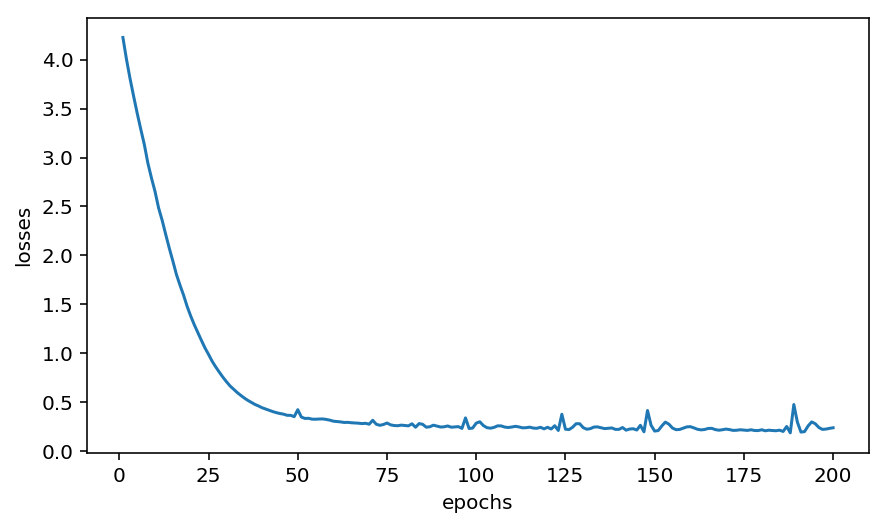

In [20]:
plt.figure(figsize=(7,4))
plt.plot(np.arange(1,iteration), loss_vec)
plt.ylabel('losses')
plt.xlabel('epochs')
plt.show()

## Generating music

We now have a trained model which has learned the patterns of a song. Let's now use this model to synthesize new music. 

<img src="images/music_gen.png" style="width:600;height:400px;">

To start off the model, we will initialize `x0` as well as the LSTM hidden and cell states (both in model.initial_state) to be zeros. 

In [21]:
def predict_and_sample_vmg(checkpoint, num_classes, lstm_size, T_y):

    samples = []
    model = djmodel(num_classes=num_classes, lstm_size=lstm_size, sampling=True)
    saver = tf.train.Saver()

    with tf.Session(config=config) as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state) 
        x0=np.zeros((1, 1, num_classes), dtype=np.bool)
        x=x0
    
        for t in range(T_y):
            feed = {model.inputs: x,
                model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)
      
            samples.append(preds)
            
            x=np.zeros((1, 1, num_classes), dtype=np.bool)
            x[:, :, np.argmax(preds)] = 1
            # Rather than sampling a value at random according to the probabilities in `preds`, 
            # this line of code actually chooses the single most likely note at each step using an argmax
    
    # numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    indices=np.argmax(samples,axis=2)
    return indices

We will generate music now. Our LSTM network generates a sequence of values. The following code generates music by first calling the `predict_and_sample_vmg()` function. These values are then post-processed into musical chords (meaning that multiple values or notes can be played at the same time). 

In [22]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
out_stream = generate_music_vmg(checkpoint=checkpoint, num_classes=num_classes, lstm_size=lstm_size, T_y=50)

Predicting new values for different set of chords.


W0815 14:22:11.089347  1120 deprecation.py:323] From C:\Users\vgkortsas\AppData\Local\Continuum\anaconda3\envs\TF_practice\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Generated 51 sounds using the predicted values for the set of chords ("1") and after pruning
Generated 50 sounds using the predicted values for the set of chords ("2") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("3") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("4") and after pruning
Generated 51 sounds using the predicted values for the set of chords ("5") and after pruning
Your generated music is saved in output/my_music.midi
